# 1. Import all Necessary libraries.

In [1]:
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
except:
    print("Libraries should be installed")

In [2]:
try:
    from sklearn.feature_extraction import DictVectorizer
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.linear_model import Ridge
except:
    print("Libraries should be installed")
    !pip install sklearn

**Looks like it the virtual environment consist all the necessary basic libaries**

Now let's delve deep, firstly by importring the data

# 2. Import Data

In [32]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)
    df = df[(df.duration>=1) & (df.duration<=58)]
    categorical = ['PULocationID', 'DOLocationID']
    
    df[categorical].astype(str)
    
    return df

In [33]:
df_train = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")
df_val = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet")

In [34]:
df_train.head() 

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.00,0.97,1.00,N,161,141,2,9.30,1.00,0.50,0.00,0.00,1.00,14.30,2.50,0.00,8.43
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.00,1.10,1.00,N,43,237,1,7.90,1.00,0.50,4.00,0.00,1.00,16.90,2.50,0.00,6.32
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.00,2.51,1.00,N,48,238,1,14.90,1.00,0.50,15.00,0.00,1.00,34.90,2.50,0.00,12.75
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.00,1.90,1.00,N,138,7,1,12.10,7.25,0.50,0.00,0.00,1.00,20.85,0.00,1.25,9.62
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.00,1.43,1.00,N,107,79,1,11.40,1.00,0.50,3.28,0.00,1.00,19.68,2.50,0.00,10.83


In [75]:
df_val.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.00,0.30,1.00,N,142,163,2,4.40,3.50,0.50,0.00,0.00,1.00,9.40,2.50,0.00,1.68
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.00,18.80,1.00,N,132,26,1,70.90,2.25,0.50,0.00,0.00,1.00,74.65,0.00,1.25,32.08
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.00,3.22,1.00,N,161,145,1,17.00,1.00,0.50,3.30,0.00,1.00,25.30,2.50,0.00,13.30
5,1,2023-02-01 00:52:40,2023-02-01 01:07:18,1.00,5.10,1.00,N,148,236,1,21.90,3.50,0.50,5.35,0.00,1.00,32.25,2.50,0.00,14.63
6,1,2023-02-01 00:12:39,2023-02-01 00:40:36,1.00,8.90,1.00,N,137,244,1,41.50,3.50,0.50,3.50,0.00,1.00,50.00,2.50,0.00,27.95


# 3. Problem Statement



The goal of this project is predict the estimated trip duration. The duration of the trip is difference between dropoff date time and pickup date time. Based on the historical data that we have we have to predict the trip dkuration. There are several features in the dataset. The dataset is taken from here https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page, we took the yellow taxi trip records from January 2023 and February 2023. We used Jan-2023 data for training the model and utilise the other data for testing the performance.

> Let us explore the dataset in detail and prepare our target label.


## Dataset Summary

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [6]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns")

There are 3066766 rows and 19 columns


<div class="alert alert-block alert-warning">
<b>We see there are 19 features in the dataset. This requires us to furthur reduce the dimensinality, hence feature engineering is essential. It is natural that for estimation of any trip duration we need the pickup location[7] and drop off location[8], which are in integer type, that means these are catagorical values decode into integers. Trip Distance is another important feature. To understand the meaning of the features in details go through this Data dictionary: <li>https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf.</li></b>

> Let us first assign our target variables
</div>

In [7]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0 days 00:08:26
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,0 days 00:06:19
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0 days 00:12:45
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0 days 00:09:37
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0 days 00:10:50


Since our target variables are datetime format, luckily we are saved we can just get the difference of them for duration. However it is still in Timedelta format, which needs to be converted to minutes. For the same in the below code we used a lamda function to convert duration feature in to minutes

<div class="alert alert-block alert-info">
    It is essential to understand the <b>distribution of data</b> to observe if there are any outliers in the data and also for prediction outliers are fatal to any model. Since we have large amount of data that is around 3 million rows, it is essential to know the <b>distribution, density and skewness of the data</b>. In the below code we have set_option for float format to 2 decimal points, which is helpful to understand the data, becuase scientific notations are generally unclear and hence this will convert them to standard notation.
</div>


In [9]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [10]:
df_train['duration'].describe(percentiles=[0.02,0.25,0.95,0.98,0.99])

count   3066766.00
mean         15.67
std          42.59
min         -29.20
2%            2.05
25%           7.12
50%          11.52
95%          36.47
98%          48.73
99%          57.25
max       10029.18
Name: duration, dtype: float64

<AxesSubplot:xlabel='duration', ylabel='Count'>

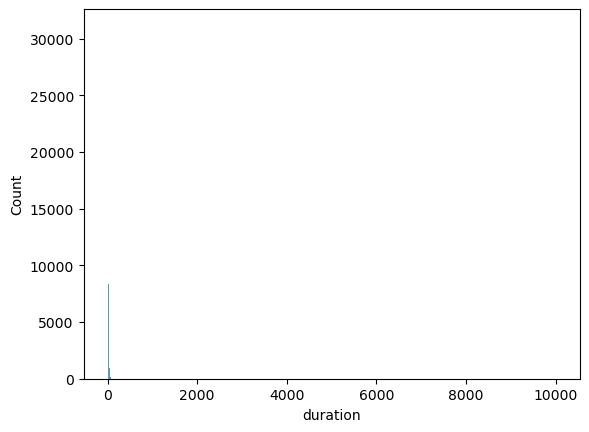

In [11]:
sns.histplot(df_train.duration)

## Understanding the histplot:

<div class="alert alert-block alert-info">
    <b>The data description shows that we have the maximum trip duration of 10029.18 minutes which is euqivalent to 6 days 9 hours. simillary the minimum value is less than 0 min which is highly unlikely, let us deal with these outliers later. For now from the disrtibution plot above we cannot understand anything because there was just one  blue line on 0 min, and the plot shows upto 10000 min. So it is clear that we the data is sparse as well the data is huge. So it is natural that the graph might not properly show the data distribution.</b>
</div>

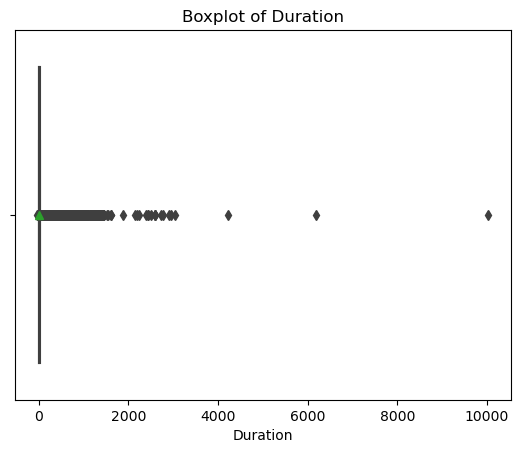

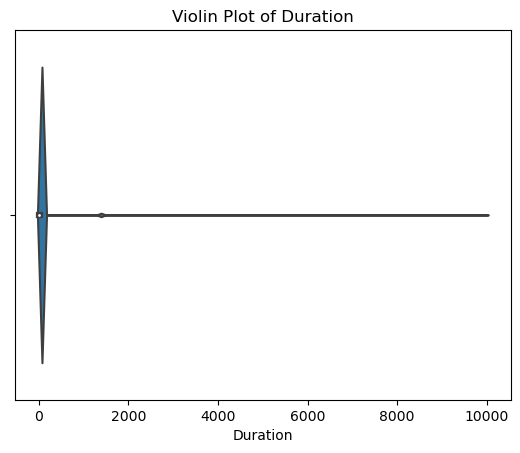

In [12]:
#box plot
sns.boxplot(x=df_train['duration'], showmeans=True)
plt.xlabel('Duration')
plt.title('Boxplot of Duration')
plt.show()

# Violin plot
sns.violinplot(x=df_train['duration'])
plt.xlabel('Duration')
plt.title('Violin Plot of Duration')
plt.show()

In [13]:
df[(df.duration>=1) & (df.duration<=60)].duration.describe(percentiles=[0.90,0.95,0.98,0.99])

count   3009173.00
mean         14.20
std           9.94
min           1.00
50%          11.55
90%          27.27
95%          34.77
98%          44.50
99%          50.27
max          60.00
Name: duration, dtype: float64

### What fraction of outliers exist?

In [15]:
outliers = (data.shape[0]/df.shape[0])*100
print(f"The fraction of records left after dropping the outliers: {outliers}")

The fraction of records left after dropping the outliers: 97.97653293404191


# 4. Feature Selection and Dictionary Vectorizer

In [56]:
def conv_dicvec(df):
    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    
    conv_dicts = df[categorical + numerical].to_dict(orient='records')
    
    return conv_dicts
    

In [57]:
train_dicts = conv_dicvec(df_train)
val_dicts = conv_dicvec(df_val)

In [64]:
print(train_dicts[0:5]," \n")

print(val_dicts[0:5])

[{'PULocationID': 161, 'DOLocationID': 141, 'trip_distance': 0.97}, {'PULocationID': 43, 'DOLocationID': 237, 'trip_distance': 1.1}, {'PULocationID': 48, 'DOLocationID': 238, 'trip_distance': 2.51}, {'PULocationID': 138, 'DOLocationID': 7, 'trip_distance': 1.9}, {'PULocationID': 107, 'DOLocationID': 79, 'trip_distance': 1.43}]  

[{'PULocationID': 142, 'DOLocationID': 163, 'trip_distance': 0.3}, {'PULocationID': 132, 'DOLocationID': 26, 'trip_distance': 18.8}, {'PULocationID': 161, 'DOLocationID': 145, 'trip_distance': 3.22}, {'PULocationID': 148, 'DOLocationID': 236, 'trip_distance': 5.1}, {'PULocationID': 137, 'DOLocationID': 244, 'trip_distance': 8.9}]


In [65]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_train

<3004711x3 sparse matrix of type '<class 'numpy.float64'>'
	with 9014133 stored elements in Compressed Sparse Row format>

In [66]:
dv = DictVectorizer()
X_val = dv.fit_transform(val_dicts)
X_val

<2851016x3 sparse matrix of type '<class 'numpy.float64'>'
	with 8553048 stored elements in Compressed Sparse Row format>

In [67]:
type(X_train)
X_train.shape

(3004711, 3)

In [68]:
type(X_val)
X_val.shape

(2851016, 3)

In [69]:
target = 'duration'
y_train = df_train[target].values

In [76]:
y_val = df_val[target].values

# 5.Model Training

<div class="alert alert-block alert-success">
    Let's train the model with Linear Regression.
</div>

In [70]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [71]:
y_pred = lr.predict(X_train)

C:\Users\gowth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gowth\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


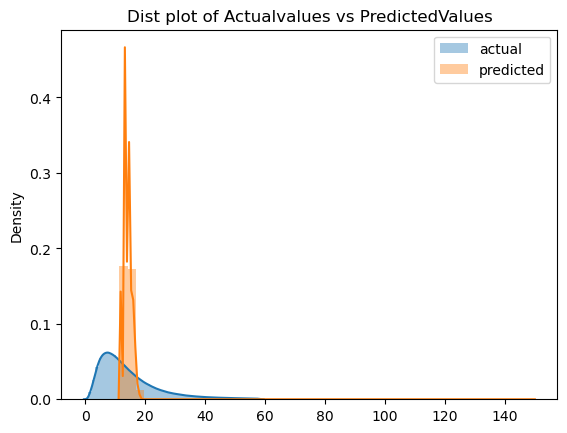

In [72]:
sns.distplot(y_train, label='actual')
sns.distplot(y_pred, label='predicted')

plt.title("Dist plot of Actualvalues vs PredictedValues")
plt.legend()

In [74]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_pred, y_train, squared = False)

9.693178790579228

In [77]:
y_pred = lr.predict(X_val)

In [78]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_pred, y_val, squared = False)

9.800602771625586

# Improvements

In [87]:
from sklearn.linear_model import Ridge

l2 = Ridge()
l2.fit(X_train, y_train)

Ridge()

In [88]:
y_pred_same = l2.predict(X_train)
y_pred_val = l2.predict(X_val)

In [89]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_pred_same, y_train, squared = False)

9.693178790579221

In [90]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_pred_val, y_val, squared = False)

9.800602771625718